In [3]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
import warnings 

# Disabling deprecation warnings that could indicate, for instance, a suspended library or feature; not task-relevant

warnings.filterwarnings("ignore") 

# Choosing styling option for how plots will appear

plt.style.use('fivethirtyeight')

In [19]:
# Configuring API
quandl.ApiConfig.api_key = 'soKQGxDL72-oxAJxSoqx'

In [21]:
# Importing data for analysis

In [23]:
df_data = quandl.get('FRED/NROUST')

In [24]:
df_data.head()

,Value
Date,
1949-01-01,5.255053
1949-04-01,5.261516
1949-07-01,5.268013
1949-10-01,5.274564
1950-01-01,5.281182


In [26]:
df_data.shape

(332, 1)

In [27]:
df_data.columns

Index(['Value'], dtype='object')

In [28]:
type(df_data)

pandas.core.frame.DataFrame

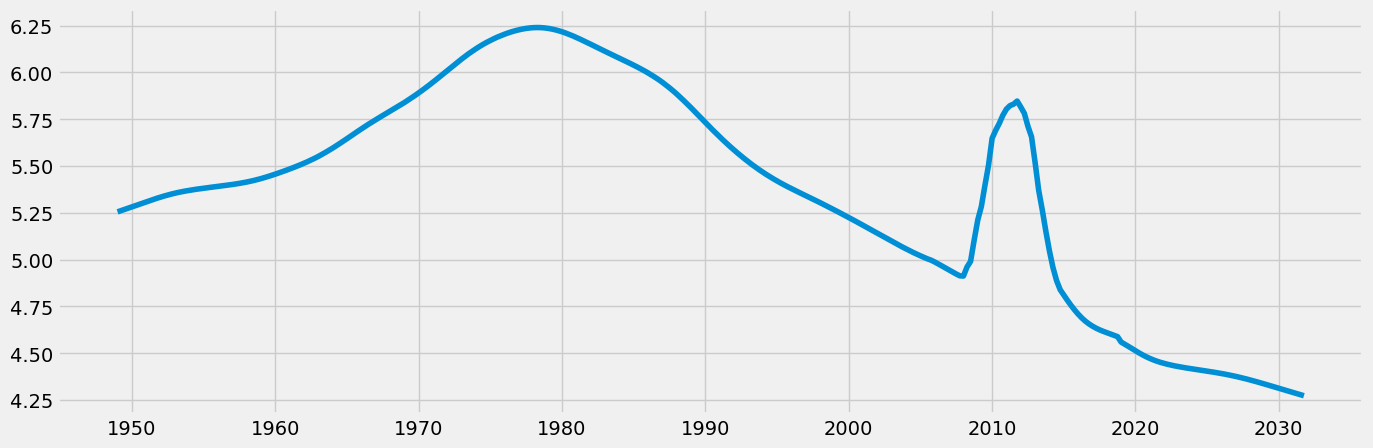

In [29]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) 
plt.plot(df_data)

In [30]:
# Check for missing values 

df_data.isnull().sum() 

Value    0
dtype: int64

In [31]:
# Check for duplicates

dups = df_data.duplicated()
dups.sum()

0

#  Subsetting and cleaning of the data

In [32]:
# Resetting index so that you can use the "Date" column as a filter

df_reset = df_data.reset_index()

In [33]:
df_reset

,Date,Value
0,1949-01-01,5.255053
1,1949-04-01,5.261516
2,1949-07-01,5.268013
3,1949-10-01,5.274564
4,1950-01-01,5.281182
...,...,...
327,2030-10-01,4.294982
328,2031-01-01,4.289282
329,2031-04-01,4.283630
330,2031-07-01,4.278029


In [35]:
df_sub = df_reset.loc[(df_reset['Date'] >= '1995-01-01') & (df_reset['Date'] < '2021-07-09')]

# # Setting the "Date" column as the index


In [36]:
from datetime import datetime

df_sub['datetime'] = pd.to_datetime(df_sub['Date']) # Create a datetime column from "Date"
df_sub = df_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
df_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
df_sub.head()

,Value
datetime,
1995-01-01,5.420172
1995-04-01,5.409451
1995-07-01,5.399091
1995-10-01,5.389050
1996-01-01,5.379276


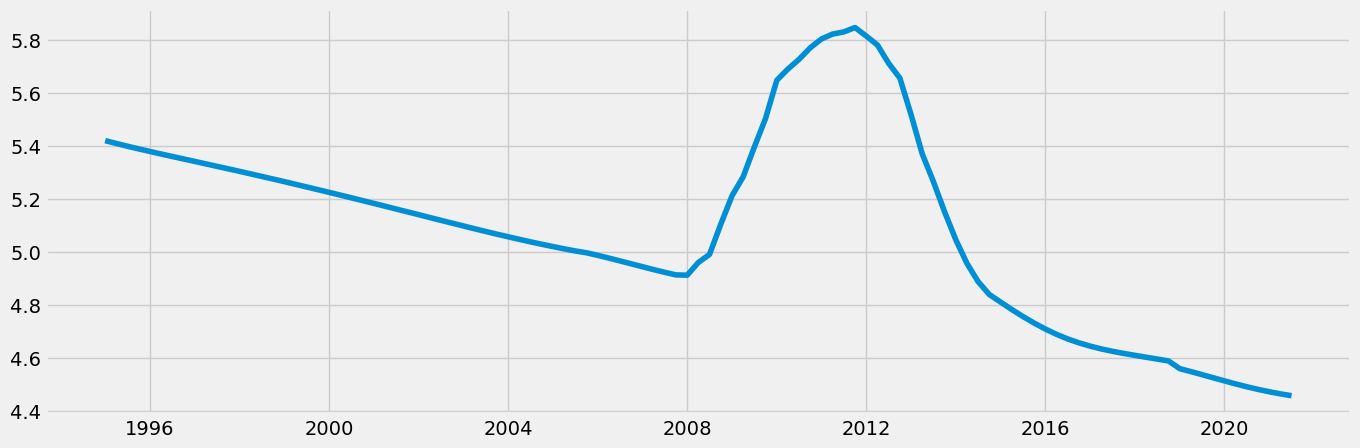

In [37]:
# Plotting the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(df_sub)

## Decomposing of the data for time-series analysis

In [38]:
# Decomposing the time series using an additive model

decomposing = sm.tsa.seasonal_decompose(df_sub, model='additive')

In [39]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

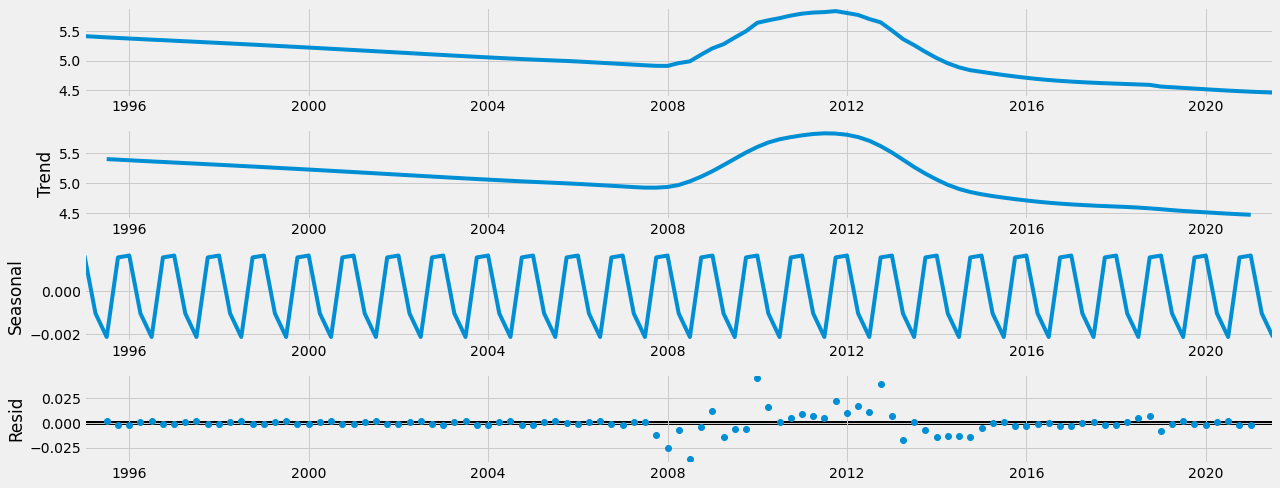

In [40]:
# Plotting the separate components

decomposing.plot()
plt.show()

The trend appear the same because the data doesn't present huge variations, but some from 2008 to 2014. The residual line presents higher variations from 2008 (housing crises in the US). The seasonal line shows that the data has seasonality, potentially promoted by the crisis and seasonal jobs.

## Testing for stationarity

In [41]:
# The adfuller() function will import from the model from statsmodels for the test; however, 
# running it will only return an array of numbers. 
# This is the resaon to define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(df_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                 -0.529968
p-value                         0.886035
Number of Lags Used            12.000000
Number of Observations Used    94.000000
Critical Value (1%)            -3.501912
Critical Value (5%)            -2.892815
Critical Value (10%)           -2.583454
dtype: float64


In order to determine the results of a statistical hypothesis test, one has to compare the test statistic to the critical value of the corresponding significance level.

If the test statistic is larger than the critical value, one can’t reject the null hypothesis. If the test statistic is smaller than the critical value, the null hypothesis could be rejected.

In this case, considering a significance level of 5%, the “Critical Value of 5% has a value of -2.893508. This is smaller than the test statistic, which is -0.491166, which means that the null hypothesis cannot be rejected.

This also means that the data is non-stationary.

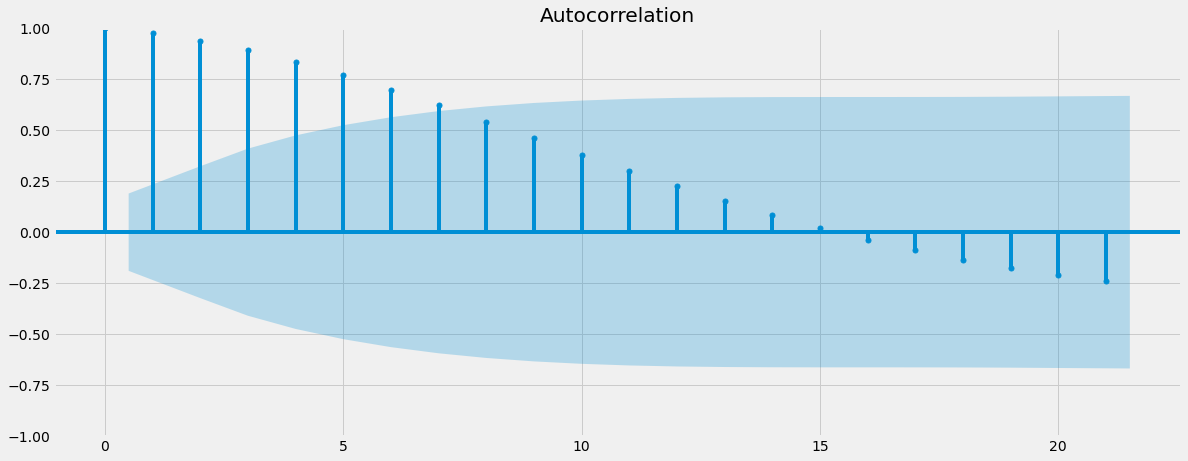

In [42]:
# Checking out autocorrelations with a plot

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Import autocorrelation and partial correlation plots.

plot_acf(df_sub)
plt.show()

The vertical lines represent the lags in the series, while the blue area represents the confidence interval. When lines go above the blue edge of the confidence interval, this means there are lags that are significantly correlated with each other. Thus, it can be deduced that the data is non-stationary.

## Stationarizing the data

In [44]:
data_different = df_sub - df_sub.shift(1) # The df.shift(1) function turns the observation to t-1, 
# making the whole data t - (t -1)

In [45]:
data_different.dropna(inplace = True) # Missing values that came about as a result of the differencing are removed. 
# They need to be removed or the Dickey-Fuller test won't run.

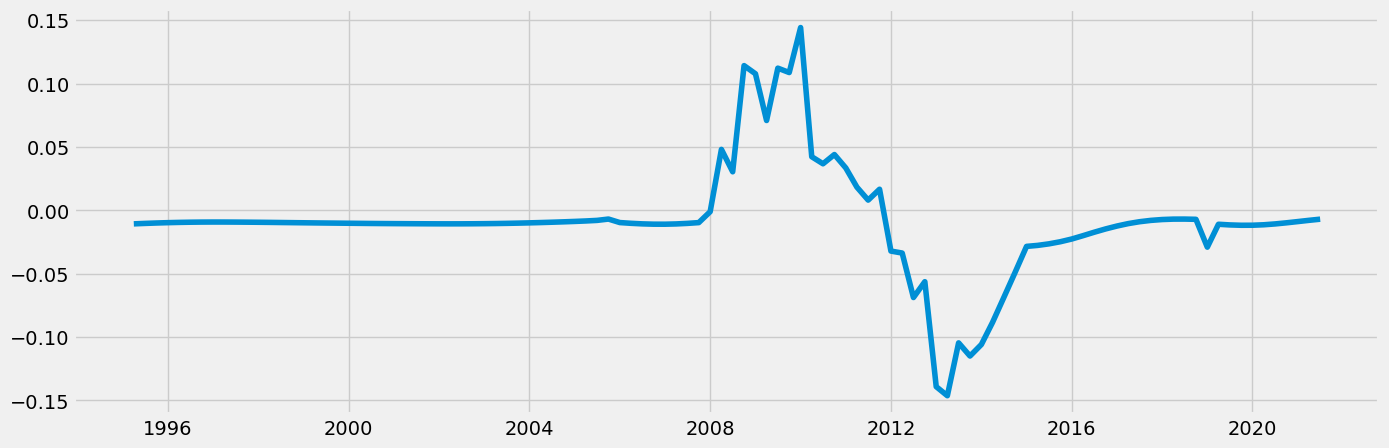

In [46]:
# Checking out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_different)

In [47]:
# Running the Dickey-Fuller-Test again

dickey_fuller(data_different)

Dickey-Fuller Stationarity test:
Test Statistic                 -3.690924
p-value                         0.004243
Number of Lags Used            11.000000
Number of Observations Used    94.000000
Critical Value (1%)            -3.501912
Critical Value (5%)            -2.892815
Critical Value (10%)           -2.583454
dtype: float64


The results means that null hypothesis cannot be rejected and the data is still non-stationary.

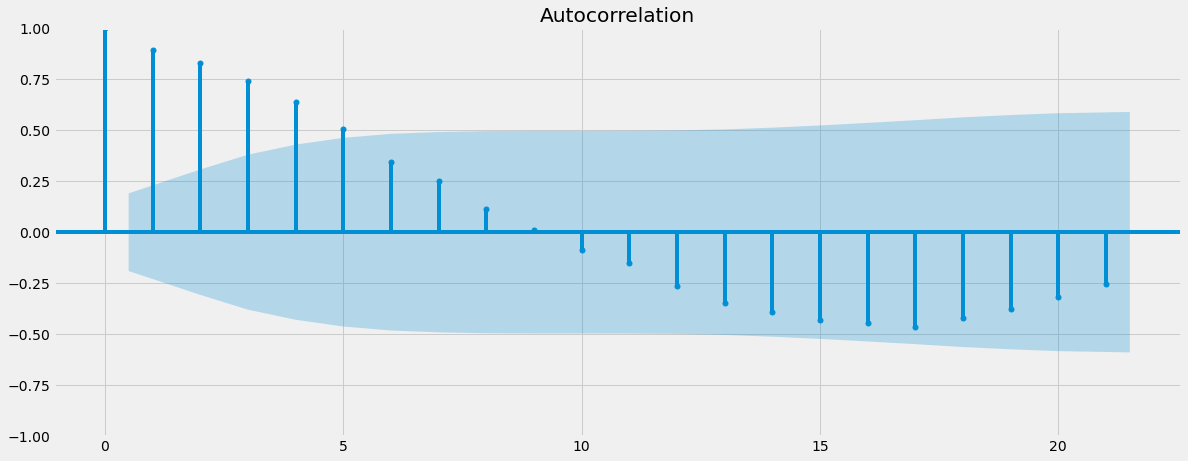

In [48]:
# Plotting the autocorrelation again

plot_acf(data_different)
plt.show()

Although the autocorrelation plot has improved, the data are still not stationary. But even though I don't see the need to conduct another analysis cycle as there is not a significant amount of vertical lines above the confidence interval = blue line.